# Fetching Data

In [1]:
!pip install ucimlrepo -q
!pip install imblearn -q

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetching dataset 
adult = fetch_ucirepo(id=2) 
  
# Converting data to single Dataframe
X = adult.data.features 
y = adult.data.targets 
X["Target"] = y
data = X.copy()

# Gettring required data
columns_of_interest = ['age', 'workclass', 'education', 
                       'marital-status', 'occupation', 'sex', 'hours-per-week', 'Target']

data = data[columns_of_interest]
data.head()

,age,workclass,education,marital-status,occupation,sex,hours-per-week,Target
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Male,40,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Male,13,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Male,40,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Male,40,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Female,40,<=50K


# Data Preparation

In [4]:
# Dropping NAN
data = data.dropna()

In [5]:
# Encoding Target
mapper = {'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1}
data.Target = data.Target.map(mapper)

In [6]:
data.shape

(47876, 8)

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Balancing Data
sampler = RandomUnderSampler()
X_new, y_new = sampler.fit_resample(data.drop(columns=['Target']), data['Target'])

X_new["Target"] = y_new
data = X_new

In [8]:
data.shape

(23226, 8)

In [9]:
from sklearn.model_selection import train_test_split

# Split the Data
data_new = data.sample(3000)
train, test = train_test_split(data_new, test_size=0.2, random_state=42)

# Decision Tree Implementation

In [19]:
import numpy as np
import pandas as pd

class DecisionTreeClassifier:
    """
    A custom Decision Tree Classifier for both numerical and categorical data.
    """

    def __init__(self, max_depth=5, min_size=10):
        """
        Initialize the Decision Tree Classifier.

        Parameters:
            max_depth (int): Maximum depth of the tree.
            min_size (int): Minimum group size for splitting.
        """
        self.max_depth = max_depth
        self.min_size = min_size
        self.tree = None

    def gini_impurity(self, groups, classes):
        """
        Calculate the Gini Impurity for a split.

        Parameters:
            groups (list of DataFrames): Groups created by a split.
            classes (array-like): Unique class labels in the dataset.

        Returns:
            float: Gini impurity score for the split.
        """
        n_instances = float(sum([len(group) for group in groups]))  # Total instances in all groups
        gini = 0.0
        for group in groups:
            size = float(len(group))  # Size of the current group
            if size == 0:
                continue  # Skip empty groups
            score = 0.0
            # Calculate the score for each class in the group
            for class_val in classes:
                proportion = (group.iloc[:, -1] == class_val).sum() / size
                score += proportion ** 2
            # Add the weighted Gini impurity for the group
            gini += (1.0 - score) * (size / n_instances)
        return gini

    def test_split(self, index, value, dataset):
        """
        Split a dataset based on an attribute and its value.

        Parameters:
            index (int): Index of the attribute to split on.
            value: Value of the attribute to split at.
            dataset (DataFrame): Dataset to split.

        Returns:
            tuple: Two DataFrames, left and right groups.
        """
        if dataset.dtypes[index] == 'object':  # For categorical data
            left = dataset[dataset.iloc[:, index] == value]
            right = dataset[dataset.iloc[:, index] != value]
        else:  # For numerical data
            left = dataset[dataset.iloc[:, index] < value]
            right = dataset[dataset.iloc[:, index] >= value]
        return left, right

    def get_best_split(self, dataset):
        """
        Find the best attribute and value to split the dataset.

        Parameters:
            dataset (DataFrame): The dataset to evaluate.

        Returns:
            dict: Information about the best split (index, value, groups).
        """
        class_values = dataset.iloc[:, -1].unique()  # Unique class labels
        best_index, best_value, best_score, best_groups = None, None, float('inf'), None
        # Iterate over each attribute
        for index in range(dataset.shape[1] - 1):  # Exclude the target column
            for value in dataset.iloc[:, index].unique():  # Check all unique values
                groups = self.test_split(index, value, dataset)
                gini = self.gini_impurity(groups, class_values)
                # Update the best split if a lower Gini score is found
                if gini < best_score:
                    best_index, best_value, best_score, best_groups = index, value, gini, groups
        return {'index': best_index, 'value': best_value, 'groups': best_groups}

    def to_terminal(self, group):
        """
        Create a terminal node value.

        Parameters:
            group (DataFrame): Dataset group for which to create the terminal node.

        Returns:
            int: The most common class label in the group.
        """
        outcomes = group.iloc[:, -1]
        return outcomes.value_counts().idxmax()

    def split(self, node, depth):
        """
        Recursively split nodes to build the decision tree.

        Parameters:
            node (dict): The current node.
            depth (int): Current depth of the tree.
        """
        left, right = node['groups']
        del node['groups']  # Remove groups from the node after splitting
        # Check if any group is empty
        if left.empty or right.empty:
            node['left'] = node['right'] = self.to_terminal(pd.concat([left, right]))
            return
        # Check for max depth
        if depth >= self.max_depth:
            node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
            return
        # Process left child
        if len(left) <= self.min_size:
            node['left'] = self.to_terminal(left)
        else:
            node['left'] = self.get_best_split(left)
            self.split(node['left'], depth + 1)
        # Process right child
        if len(right) <= self.min_size:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_best_split(right)
            self.split(node['right'], depth + 1)

    def fit(self, train):
        """
        Build the decision tree using the training dataset.

        Parameters:
            train (DataFrame): The training dataset.
        """
        self.tree = self.get_best_split(train)
        self.split(self.tree, depth=1)

    def predict_row(self, node, row):
        """
        Predict the class label for a given row using the decision tree.

        Parameters:
            node (dict): The root node of the decision tree.
            row (Series): A row of data to predict.

        Returns:
            int: Predicted class label.
        """
        if isinstance(node['value'], str):  # Categorical split
            if row[node['index']] == node['value']:
                if isinstance(node['left'], dict):
                    return self.predict_row(node['left'], row)
                else:
                    return node['left']
            else:
                if isinstance(node['right'], dict):
                    return self.predict_row(node['right'], row)
                else:
                    return node['right']
        else:  # Numerical split
            if row[node['index']] < node['value']:
                if isinstance(node['left'], dict):
                    return self.predict_row(node['left'], row)
                else:
                    return node['left']
            else:
                if isinstance(node['right'], dict):
                    return self.predict_row(node['right'], row)
                else:
                    return node['right']

    def predict(self, test):
        """
        Predict the class labels for a given test dataset.

        Parameters:
            test (DataFrame): Test dataset.

        Returns:
            list: List of predicted class labels.
        """
        return [self.predict_row(self.tree, row) for _, row in test.iterrows()]


    def plot_tree(self, node=None, column_names=None, depth=0, x=0.5, y=1.0, vertical_spacing=0.15, ax=None, level_width=1.5):
        """
        Recursively plot the decision tree.

        Parameters:
            node (dict): The current node of the tree. Defaults to the root node.
            column_names (list): List of column names for better interpretability.
            depth (int): Current depth of the tree.
            x (float): x-coordinate of the current node.
            y (float): y-coordinate of the current node.
            vertical_spacing (float): Vertical space between levels of the tree.
            ax (matplotlib.axes._axes.Axes): Matplotlib Axes object.
            level_width (float): Horizontal space between nodes at the same level.
        """
        if node is None:
            node = self.tree  # Start from the root node
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.set_axis_off()

        # Check if the node is a leaf
        if not isinstance(node, dict):
            ax.annotate(
                f"Class: {node}",
                (x, y),
                xytext=(0, -15),
                textcoords='offset points',
                ha='center',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightblue')
            )
            return

        # Determine the condition for splitting
        if column_names:
            if isinstance(node['value'], str):  # Categorical split
                condition = f"{column_names[node['index']]} == {node['value']}"
            else:  # Numerical split
                condition = f"{column_names[node['index']]} < {node['value']:.2f}"
        else:
            condition = f"X[{node['index']}] < {node['value']:.2f}"

        # Annotate the current node
        ax.annotate(
            condition,
            (x, y),
            xytext=(0, -15),
            textcoords='offset points',
            ha='center',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
        )

        # Calculate positions for left and right children
        left_x = x - level_width / (2 ** depth)
        right_x = x + level_width / (2 ** depth)
        child_y = y - vertical_spacing

        # Draw lines to children
        ax.plot([x, left_x], [y, child_y], 'k-')
        ax.plot([x, right_x], [y, child_y], 'k-')

        # Recursively plot left and right children
        self.plot_tree(node['left'], column_names, depth + 1, left_x, child_y, vertical_spacing, ax, level_width)
        self.plot_tree(node['right'], column_names, depth + 1, right_x, child_y, vertical_spacing, ax, level_width)

        # Show the plot
        if depth == 0:
            plt.show()

In [11]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd

# Initialize lists to store results
results = []

# Define ranges for max_depth and min_size
depth_range = range(1, 5)  # Test depths from 1 to 10
min_size_range = range(1, 7, 2)  # Test min_samples from 1 to 20, stepping by 2

# Iterate over the parameter grid
for max_depth in depth_range:
    for min_size in min_size_range:
        # Train the decision tree with the current parameters
        dt = DecisionTreeClassifier(max_depth=max_depth, min_size=min_size)
        dt.fit(train)
        
        # Make predictions on the test set
        predictions = dt.predict(test)
        
        # Compute the F1 score
        f1 = f1_score(test.iloc[:, -1], predictions, average='binary')  # Adjust for binary classification
        
        # Store the results
        results.append({
            'max_depth': max_depth,
            'min_size': min_size,
            'f1_score': f1
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
display(results_df)

# Find the best parameters
best_result = results_df.loc[results_df['f1_score'].idxmax()]
print("Best Parameters:")
print(f"Max Depth: {best_result['max_depth']}")
print(f"Min Samples: {best_result['min_size']}")
print(f"F1 Score: {best_result['f1_score']}")

,max_depth,min_size,f1_score
0,1,1,0.766021
1,1,3,0.766021
2,1,5,0.766021
3,2,1,0.765507
4,2,3,0.765507
5,2,5,0.765507
6,3,1,0.789773
7,3,3,0.789773
8,3,5,0.789773
9,4,1,0.786227


Best Parameters:
Max Depth: 3.0
Min Samples: 1.0
F1 Score: 0.7897727272727273


In [20]:
dt = DecisionTreeClassifier(max_depth=3, min_size=1)
dt.fit(train)  # Train the model
predictions = dt.predict(test)

Model Evaluation Metrics:
Accuracy: 0.7533
Precision: 0.6985
Recall: 0.9085
F1 Score: 0.7898

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.59      0.70       294
        >50K       0.70      0.91      0.79       306

    accuracy                           0.75       600
   macro avg       0.78      0.75      0.75       600
weighted avg       0.78      0.75      0.75       600



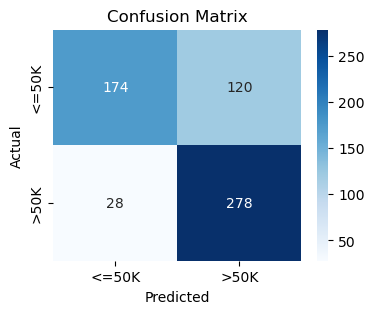

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)

def evaluate_model(y_actual, y_predicted, class_labels=None):
    """
    Evaluate a classification model with various metrics and plots.

    Parameters:
        y_actual (array-like): True labels.
        y_predicted (array-like): Predicted labels.
        y_prob (array-like, optional): Predicted probabilities for the positive class (for ROC curve).
        class_labels (list, optional): Class labels for confusion matrix.
    
    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    # Calculate metrics
    accuracy = accuracy_score(y_actual, y_predicted)
    precision = precision_score(y_actual, y_predicted, average='binary' if len(set(y_actual)) == 2 else 'macro')
    recall = recall_score(y_actual, y_predicted, average='binary' if len(set(y_actual)) == 2 else 'macro')
    f1 = f1_score(y_actual, y_predicted, average='binary' if len(set(y_actual)) == 2 else 'macro')
    report = classification_report(y_actual, y_predicted, target_names=class_labels) if class_labels else classification_report(y_actual, y_predicted)

    # Display metrics
    print("Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_actual, y_predicted)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(test.Target, predictions, class_labels=["<=50K", ">50K"])

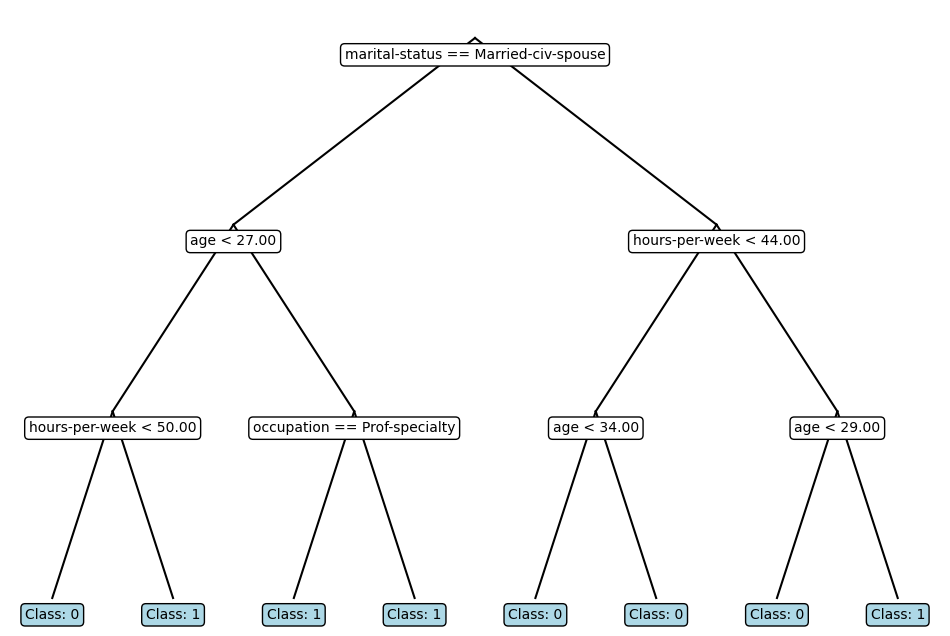

In [22]:
dt.plot_tree(column_names=train.columns[:-1].tolist())